In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [16]:
# Generating a random binary string of length 50
string_length = 50
random_string = torch.randint(0, 2, (string_length,)).float()

# Parameters
num_kernel = 10  # Number of kernels
M = 5            # Maximum kernel length
eps = 0.5        # Epsilon for relu_distance calculation
epochs = 10      # Number of epochs for optimization
lr = 0.01        # Learning rate

# Debug: Print the generated random string
print("Generated random binary string:")
print(random_string)


Generated random binary string:
tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.])


In [17]:
class Seqs(nn.Module):
    def __init__(self, dim, num_kernels):
        super(Seqs, self).__init__()
        self.dim = dim  # Kernel length
        self.num_kernels = num_kernels  # Number of kernels
        self.p = nn.Parameter(torch.rand(num_kernels, dim, dtype=torch.float32), requires_grad=True)

    def forward(self):
        # Debug: Check that the parameter p requires gradients
        print(f"Parameter p (before forward, requires_grad={self.p.requires_grad}):\n{self.p}")

        # Forward computation
        prob = self.p  # Kernel probabilities
        logits = torch.stack((prob, 1 - prob), dim=-1)

        # Debug: Check that logits is connected to the computation graph
        print(f"Logits grad_fn: {logits.grad_fn}")

        S = F.gumbel_softmax(logits, tau=0.1, hard=True, dim=-1)[..., 0]

        # Debug: Check that S is connected to the computation graph
        print(f"Output S (grad_fn={S.grad_fn}):\n{S}")

        return S


In [34]:
"""# Example of usage during training
seq_model = Seqs(2, 3)  # Model with dimension 2 and 3 kernels
optimizer = torch.optim.Adam(seq_model.parameters(), lr=0.01)

# Dummy input
input_string = torch.randint(0, 2, (10,)).float()  # Random binary string

# Forward pass
output = seq_model()

# Dummy loss
loss = output.sum()

# Backward pass
loss.backward()

# Debug: Gradient of p
print(f"Gradient of p after backward:\n{seq_model.p.grad}")"""

Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[0.6884, 0.2354],
        [0.4138, 0.6820],
        [0.5644, 0.5714]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x14842e3d0>
Output S (grad_fn=<SelectBackward0 object at 0x14842e3d0>):
tensor([[1., 0.],
        [0., 1.],
        [0., 0.]], grad_fn=<SelectBackward0>)
Gradient of p after backward:
tensor([[1.4576e+00, 8.8898e-10],
        [2.4518e-10, 7.3460e-08],
        [6.3319e-02, 4.3073e-11]])


In [19]:
# Generate a model for each dimension from 1 to M
seq_models = [Seqs(dim, num_kernel) for dim in range(1, M + 1)]

# Generate binary kernels directly from the model (without detach)
binary_kernels = [model() for model in seq_models]

# Debug: Display the generated binary kernels
for dim, kernels in enumerate(binary_kernels, start=1):
    print(f"Binary kernels (dim {dim}):")
    print(kernels)


Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[0.3802],
        [0.7094],
        [0.4730],
        [0.1764],
        [0.0775],
        [0.8040],
        [0.5420],
        [0.7895],
        [0.4264],
        [0.9264]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x14842e3d0>
Output S (grad_fn=<SelectBackward0 object at 0x14842e3d0>):
tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.]], grad_fn=<SelectBackward0>)
Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[1.1231e-01, 2.9194e-04],
        [3.6154e-01, 9.6471e-01],
        [6.7084e-01, 7.9684e-02],
        [3.1580e-01, 1.8933e-01],
        [3.0300e-01, 2.6501e-01],
        [6.6091e-01, 4.7134e-01],
        [9.4994e-01, 2.5308e-01],
        [9.7226e-01, 5.3829e-01],
        [8.3720e-01, 6.1209e-01],
        [1.9945e-01, 8.1742e-01]], requires_grad=True)
Logits grad

In [20]:
def ZivEntropy(binary_kernels, string, eps=0.5):

    ziv_probs = []

    for k, kernels in enumerate(binary_kernels, start=1):
        # Generate patches of length k
        patches = string.unfold(0, k, 1)

        # Debug: Check that patches are part of the computational graph
        print(f"Patches (k={k}): requires_grad={patches.requires_grad}, shape={patches.shape}")

        # Manual calculation of Manhattan distances
        distances = torch.abs(patches.unsqueeze(1) - kernels.unsqueeze(0)).sum(dim=-1)

        # Debug: Check that distances are part of the computational graph
        print(f"Manhattan distances (k={k}): requires_grad={distances.requires_grad}, grad_fn={distances.grad_fn}")

        # ReLU distance calculations
        relu_distances = F.relu(eps - distances + 1e-6) / eps

        # Debug: Check that relu_distances are connected to the graph
        print(f"ReLU distances (k={k}): requires_grad={relu_distances.requires_grad}, grad_fn={relu_distances.grad_fn}")

        # Probability calculations
        probs = relu_distances.sum(dim=0) / (len(patches) * num_kernel)

        # Debug: Check that probs are connected to the graph
        print(f"Probabilities (unnormalized) (k={k}): requires_grad={probs.requires_grad}, grad_fn={probs.grad_fn}")

        # Normalization of probabilities
        normalized_probs = probs / probs.sum()

        # Debug: Check that normalized_probs support gradients
        print(f"Normalized probabilities (k={k}): requires_grad={normalized_probs.requires_grad}, grad_fn={normalized_probs.grad_fn}")

        ziv_probs.append(normalized_probs)

    return ziv_probs


In [35]:
"""# Test of the ZivEntropy function with an example
dim = 3  # Kernel dimension
num_kernels = 5  # Number of kernels
string_length = 10  # Length of the binary string

# Creating a Seqs model
seq_model = Seqs(dim, num_kernels)

# Generating binary kernels
binary_kernels = [seq_model()]  # Simulating one dimension with binary kernels

# Debug: Check that the binary kernels are connected to the computation graph
for kernel_index, kernel in enumerate(binary_kernels, start=1):
    print(f"Binary kernel {kernel_index}: requires_grad={kernel.requires_grad}")

# Generating a random binary string
random_string = torch.randint(0, 2, (string_length,), dtype=torch.float32, requires_grad=True)

# Debug: Check if the binary string requires gradients
print(f"Does the binary string require gradients? {'True' if random_string.requires_grad else 'False'}")

# Epsilon
eps = 0.5

# Test of the ZivEntropy function
ziv_probs = ZivEntropy(binary_kernels, random_string, eps=eps)

# Debug: Print probabilities to verify connection to the computation graph
for k, probs in enumerate(ziv_probs, start=1):
    print(f"Normalized probabilities (dim={k}):\n{probs}")
    print(f"Probabilities grad_fn: {probs.grad_fn}")
    print(f"Do probabilities (dim={k}) require gradients? {'True' if probs.requires_grad else 'False'}")"""


Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[0.0627, 0.4270, 0.0088],
        [0.9394, 0.7750, 0.8359],
        [0.2598, 0.8644, 0.7223],
        [0.6523, 0.7576, 0.7315],
        [0.0292, 0.4759, 0.1184]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x168da4610>
Output S (grad_fn=<SelectBackward0 object at 0x168da4610>):
tensor([[1., 1., 0.],
        [1., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], grad_fn=<SelectBackward0>)
Binary kernel 1: requires_grad=True
Does the binary string require gradients? True
Patches (k=1): requires_grad=True, shape=torch.Size([10, 1])
Manhattan distances (k=1): requires_grad=True, grad_fn=<SumBackward1 object at 0x168da4220>
ReLU distances (k=1): requires_grad=True, grad_fn=<DivBackward0 object at 0x168da4220>
Probabilities (unnormalized) (k=1): requires_grad=True, grad_fn=<DivBackward0 object at 0x168da4220>
Normalized probabilities (k=1): requires_grad=True, grad_fn=

In [22]:
def ZivEntropyLoss(ziv_probs):

    entropies_per_dim = []

    for dim_index, probs in enumerate(ziv_probs, start=1):
        # Avoid division by 0 and log(0) by adding a small epsilon
        probs = probs + 1e-8

        # Compute H for each probability value
        H_values = -(probs * probs.log())

        # Compute the mean of H for this dimension
        H_mean = H_values.mean()

        # Debug: Print the entropy calculated for the current dimension
        print(f"Entropy calculated for dimension {dim_index} (mean): {H_mean.item()}")

        entropies_per_dim.append(H_mean)

    # Sum the mean entropies across all dimensions
    Entropies = torch.stack(entropies_per_dim).sum()
    full_entropy = torch.mean(Entropies)

    # Debug: Print the full entropy
    print(f"Calculated Full Entropy: {full_entropy.item()}")

    return full_entropy


In [36]:
"""# Test of the ZivEntropyLoss function

# Simulate normalized probabilities generated by ZivEntropy
ziv_probs = [
    torch.tensor([0.2, 0.3, 0.5], requires_grad=True),  # Probabilities for dim=1
    torch.tensor([0.1, 0.2, 0.4, 0.3], requires_grad=True),  # Probabilities for dim=2
    torch.tensor([0.3, 0.3, 0.2, 0.2], requires_grad=True)  # Probabilities for dim=3
]

# Debug: Check if tensors in ziv_probs require gradients
for dim_index, probs in enumerate(ziv_probs, start=1):
    print(f"Dimension {dim_index}: requires_grad={probs.requires_grad}")

# Compute the loss
full_entropy = ZivEntropyLoss(ziv_probs)

# Debug: Check connection to the computation graph for full_entropy
print(f"Does Full Entropy require gradients? {'True' if full_entropy.grad_fn is not None else 'False'}")

# Backpropagation to verify gradients
full_entropy.backward()

# Debug: Print gradients for each dimension
for dim_index, probs in enumerate(ziv_probs, start=1):
    print(f"Gradient for probabilities of dimension {dim_index}: {probs.grad}")
    print(f"Is gradient computed for dim {dim_index}? {'True' if probs.grad is not None else 'False'}")"""

Dimension 1: requires_grad=True
Dimension 2: requires_grad=True
Dimension 3: requires_grad=True
Entropy calculated for dimension 1 (mean): 0.3432177007198334
Entropy calculated for dimension 2 (mean): 0.31996357440948486
Entropy calculated for dimension 3 (mean): 0.34153974056243896
Calculated Full Entropy: 1.0047210454940796
Does Full Entropy require gradients? True
Gradient for probabilities of dimension 1: tensor([ 0.2031,  0.0680, -0.1023])
Is gradient computed for dim 1? True
Gradient for probabilities of dimension 2: tensor([ 0.3256,  0.1524, -0.0209,  0.0510])
Is gradient computed for dim 2? True
Gradient for probabilities of dimension 3: tensor([0.0510, 0.0510, 0.1524, 0.1524])
Is gradient computed for dim 3? True


In [24]:
# Optimizer for the model parameters
optimizer = torch.optim.Adam([param for model in seq_models for param in model.parameters()], lr=lr)

losses = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients

    # Calculate probabilities using ZivEntropy
    ziv_probs = ZivEntropy(binary_kernels, random_string, eps=eps)

    # Calculate the loss
    full_entropy = ZivEntropyLoss(ziv_probs)

    # Save the loss to the list
    losses.append(full_entropy.item())

    # Backpropagation
    full_entropy.backward(retain_graph=True)

    # Debug: Display the total entropy
    print(f"Full Entropy (Epoch {epoch + 1}): {full_entropy.item()}")

    # Debug: Gradients for each dimension
    for dim, model in enumerate(seq_models, start=1):
        print(f"Kernel gradients (dim {dim}):\n{model.p.grad}")

    # Update the parameters
    optimizer.step()


Patches (k=1): requires_grad=False, shape=torch.Size([50, 1])
Manhattan distances (k=1): requires_grad=True, grad_fn=<SumBackward1 object at 0x148432a30>
ReLU distances (k=1): requires_grad=True, grad_fn=<DivBackward0 object at 0x148432a30>
Probabilities (unnormalized) (k=1): requires_grad=True, grad_fn=<DivBackward0 object at 0x148432a30>
Normalized probabilities (k=1): requires_grad=True, grad_fn=<DivBackward0 object at 0x148432a30>
Patches (k=2): requires_grad=False, shape=torch.Size([49, 2])
Manhattan distances (k=2): requires_grad=True, grad_fn=<SumBackward1 object at 0x148432a30>
ReLU distances (k=2): requires_grad=True, grad_fn=<DivBackward0 object at 0x148432a30>
Probabilities (unnormalized) (k=2): requires_grad=True, grad_fn=<DivBackward0 object at 0x148432a30>
Normalized probabilities (k=2): requires_grad=True, grad_fn=<DivBackward0 object at 0x148432a30>
Patches (k=3): requires_grad=False, shape=torch.Size([48, 3])
Manhattan distances (k=3): requires_grad=True, grad_fn=<SumB

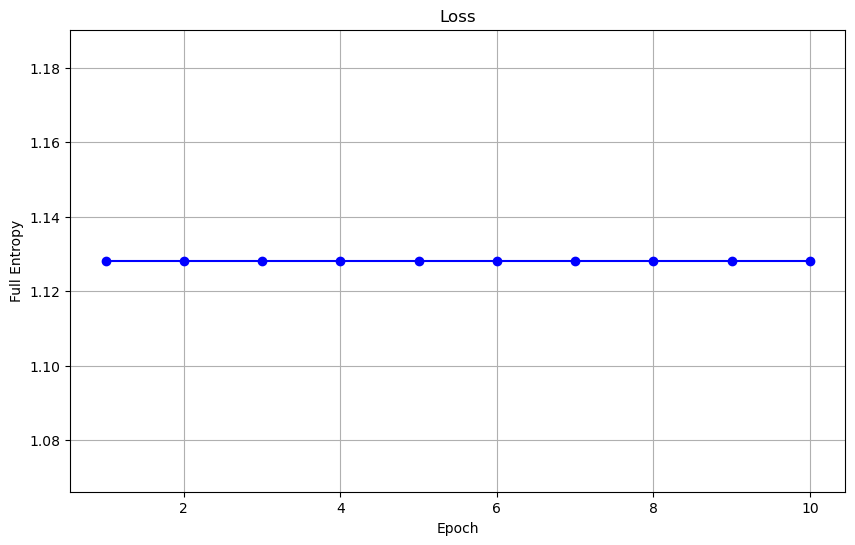

In [25]:
# Plot 
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Full Entropy')
plt.grid(True)
plt.show()

In [26]:
for i, model in enumerate(seq_models):
    print(f"Kernel {i + 1} requires_grad: {model.p.requires_grad}")


Kernel 1 requires_grad: True
Kernel 2 requires_grad: True
Kernel 3 requires_grad: True
Kernel 4 requires_grad: True
Kernel 5 requires_grad: True


In [27]:
test_loss = seq_models[4].p.sum()  # Compute the sum of the parameter p for the model with dimension 5
test_loss.backward()  # Backpropagation to calculate gradients

# Print the gradient of the parameter p for the model with dimension 5
print(f"Test gradient for kernel 5: {seq_models[4].p.grad}")


Test gradient for kernel 5: tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


In [28]:
# Optimization
optimizer.step()  # Update parameters

# Check the updated kernel values for the model with dimension 5
print(f"Updated values for the kernel with dimension 5 (p):\n{seq_models[4].p.data}")

Updated values for the kernel with dimension 5 (p):
tensor([[0.9019, 0.5926, 0.6852, 0.2181, 0.5184],
        [0.7784, 0.2038, 0.8291, 0.2850, 0.8106],
        [0.0524, 0.7350, 0.3585, 0.1832, 0.1052],
        [0.6060, 0.2092, 0.8584, 0.4746, 0.4606],
        [0.0890, 0.7307, 0.1595, 0.0697, 0.2404],
        [0.2852, 0.2753, 0.5347, 0.5354, 0.4609],
        [0.7004, 0.4422, 0.5694, 0.5735, 0.3056],
        [0.0447, 0.2264, 0.1978, 0.2848, 0.0719],
        [0.2936, 0.0247, 0.4805, 0.4568, 0.7132],
        [0.4125, 0.1354, 0.7763, 0.6909, 0.5115]])


In [29]:
# Apply forward pass for all models
binary_kernels = [seq_model() for seq_model in seq_models]

# Print the binary kernel result corresponding to dimension 5
print("Generated binary kernel for Dim 5:")
print(binary_kernels[4])  # The kernel for dimension 5

Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[0.3802],
        [0.7094],
        [0.4730],
        [0.1764],
        [0.0775],
        [0.8040],
        [0.5420],
        [0.7895],
        [0.4264],
        [0.9264]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x168d8c820>
Output S (grad_fn=<SelectBackward0 object at 0x168d8c820>):
tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]], grad_fn=<SelectBackward0>)
Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[1.1231e-01, 2.9194e-04],
        [3.6154e-01, 9.6471e-01],
        [6.7084e-01, 7.9684e-02],
        [3.1580e-01, 1.8933e-01],
        [3.0300e-01, 2.6501e-01],
        [6.6091e-01, 4.7134e-01],
        [9.4994e-01, 2.5308e-01],
        [9.7226e-01, 5.3829e-01],
        [8.3720e-01, 6.1209e-01],
        [1.9945e-01, 8.1742e-01]], requires_grad=True)
Logits grad

In [30]:
for dim, probs in enumerate(ziv_probs):
    print(f"Probabilities (dim {dim + 1}): {probs}")

Probabilities (dim 1): tensor([0.1040, 0.0960, 0.0960, 0.1040, 0.0960, 0.1040, 0.0960, 0.1040, 0.0960,
        0.1040], grad_fn=<DivBackward0>)
Probabilities (dim 2): tensor([0.0984, 0.0984, 0.0984, 0.0984, 0.0984, 0.0984, 0.0984, 0.1066, 0.1066,
        0.0984], grad_fn=<DivBackward0>)
Probabilities (dim 3): tensor([0.1111, 0.0952, 0.0794, 0.1111, 0.1111, 0.1111, 0.0952, 0.0794, 0.1111,
        0.0952], grad_fn=<DivBackward0>)
Probabilities (dim 4): tensor([0.0938, 0.1250, 0.0625, 0.1250, 0.1562, 0.1250, 0.1250, 0.0625, 0.0625,
        0.0625], grad_fn=<DivBackward0>)
Probabilities (dim 5): tensor([0.1667, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.1667, 0.0000, 0.1667,
        0.0833], grad_fn=<DivBackward0>)


In [31]:
for i, probs in enumerate(ziv_probs):
    print(f"Probabilities (Dim {i + 1}): {probs.sum().item()}")


Probabilities (Dim 1): 1.0000001192092896
Probabilities (Dim 2): 1.0
Probabilities (Dim 3): 0.9999999403953552
Probabilities (Dim 4): 1.0
Probabilities (Dim 5): 0.9999999403953552


In [32]:
# Save a copy of the initial kernel for dimension 1
initial_dim1_kernel = seq_models[0].p.clone().detach()

# Perform the forward pass to generate the binary kernel
binary_kernels = [seq_model() for seq_model in seq_models]

# Get the updated binary kernel for dimension 1
updated_dim1_binary_kernel = binary_kernels[0].detach()

# Compare the initial kernel with the updated (binary) kernel after the forward pass
print("\nInitial kernel for dimension 1:")
print(initial_dim1_kernel)

print("\nUpdated (binary) kernel for dimension 1 after the forward pass:")
print(updated_dim1_binary_kernel)

# Difference between the initial kernel and the updated (binary) kernel
difference = updated_dim1_binary_kernel - initial_dim1_kernel
print("\nDifference between initial and updated (binary) kernel (dim 1):")
print(difference)



Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[0.3802],
        [0.7094],
        [0.4730],
        [0.1764],
        [0.0775],
        [0.8040],
        [0.5420],
        [0.7895],
        [0.4264],
        [0.9264]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x1576bc8b0>
Output S (grad_fn=<SelectBackward0 object at 0x1576bc8b0>):
tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]], grad_fn=<SelectBackward0>)
Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[1.1231e-01, 2.9194e-04],
        [3.6154e-01, 9.6471e-01],
        [6.7084e-01, 7.9684e-02],
        [3.1580e-01, 1.8933e-01],
        [3.0300e-01, 2.6501e-01],
        [6.6091e-01, 4.7134e-01],
        [9.4994e-01, 2.5308e-01],
        [9.7226e-01, 5.3829e-01],
        [8.3720e-01, 6.1209e-01],
        [1.9945e-01, 8.1742e-01]], requires_grad=True)
Logits grad

In [33]:
# Save a copy of the initial kernels
initial_kernels = [seq_model.p.clone().detach() for seq_model in seq_models]

# Perform the forward pass to generate the updated binary kernels
binary_kernels = [seq_model() for seq_model in seq_models]

# Comparison between initial and updated kernels
print("\n--- Comparison between initial and updated kernels ---")
for dim_index, (initial_kernel, binary_kernel) in enumerate(zip(initial_kernels, binary_kernels)):
    print(f"Dimension {dim_index + 1}:")
    print(f"Initial Kernel:\n{initial_kernel}")
    print(f"Updated (binary) Kernel:\n{binary_kernel}")
    difference = binary_kernel - initial_kernel
    print(f"Difference:\n{difference}")



Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[0.3802],
        [0.7094],
        [0.4730],
        [0.1764],
        [0.0775],
        [0.8040],
        [0.5420],
        [0.7895],
        [0.4264],
        [0.9264]], requires_grad=True)
Logits grad_fn: <StackBackward0 object at 0x1576bca60>
Output S (grad_fn=<SelectBackward0 object at 0x1576bca60>):
tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.]], grad_fn=<SelectBackward0>)
Parameter p (before forward, requires_grad=True):
Parameter containing:
tensor([[1.1231e-01, 2.9194e-04],
        [3.6154e-01, 9.6471e-01],
        [6.7084e-01, 7.9684e-02],
        [3.1580e-01, 1.8933e-01],
        [3.0300e-01, 2.6501e-01],
        [6.6091e-01, 4.7134e-01],
        [9.4994e-01, 2.5308e-01],
        [9.7226e-01, 5.3829e-01],
        [8.3720e-01, 6.1209e-01],
        [1.9945e-01, 8.1742e-01]], requires_grad=True)
Logits grad